This notebook was used to test out image augmentation techniques. The final file to run would be `generate_dataset.py`

In [1]:
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import random
from scipy.stats import norm
import uuid

In [20]:
def draw_bounding_rect(img, start_point, end_point):
    """
    Returns an image with bounding rectangle drawn
    
    img: Image to draw on
    start_point: (x, y) representing the topleft of the rectangle
    end_point: (x, y) representing the bottomright of the rectangle
    """

    return cv2.rectangle(img, start_point, end_point, (255, 0, 0), thickness=5)

In [9]:
def stack_images(img1, img2, h_offset, w_offset, keep_black_background = True):
    """
    Stacks img2 over img1
    
    img1: Background image
    img2: Foreground image
    h_offset: How far from the top (in px) img2 is from the top border of img1
    w_offset: How far from the left (in px) img1 is from the left border of img1
    keep_black_background: Whether the black background of img2 is to be kept
    """
    # I want to put at (x, y), So I create a ROI
    rows, cols, channels = img2.shape
    roi = img1[h_offset:rows + h_offset, w_offset:cols + w_offset]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Put logo in ROI and modify the main image
    if keep_black_background:
        dst = img2_fg # Keep black background on image
    else:
        dst = cv2.add(img1_bg,img2_fg) # Remove black background from image

    img1[h_offset:rows + h_offset, w_offset:cols + w_offset] = dst
    return img1

def generate_yolo_label(class_index, h1, w1, h2, w2, h_offset, w_offset):
    """
    Generate annotations for yolov5 given the parameters
    h1: Height of background image
    w1: Width of background image
    h2: Height of foreground image
    w2: Width of foreground image
    h_offset: Distance (in px) the foreground image is from the top of the image
    w_offset: Distance (in px) the foreground image is from the left of the image
    """

    return "{} {} {} {} {}".format(class_index, (w_offset + w2 / 2) / w1, (h_offset + h2 / 2) / h1, w2 / w1, h2 / h1)

def generate_classes(target_dir):
    """
    Generate a list of classes present in `target_dir`
    """
    classes = [file_name.split('.')[0] for file_name in os.listdir(target_dir)]
    classes.sort()
    return classes
    
def get_class_index(classes, foreground_image_path):
    """
    Get the index of the class that the image `foreground_image_path` belongs to

    classes: List of classes
    foreground_image_path: Path to image
    """
    image_name = foreground_image_path.split(os.path.sep)[-1].split('.')[0]
    return classes.index(image_name)

def crop_image(image, x, y, w, h):
    """
    Crops an image given parameters

    image: Image to crop
    x: x-coordinate of top left of resultant image
    y: y-coordinate of top left of resultant image
    """
    
    new_image = image[y: y + h, x: x + w]
    return new_image

def rotate_image(image, anticlockwise_angle):
    """
    Rotates the image anticlockwise by `anticlockwise_angle` degrees
    image: The image to rotate
    anticlockwise_angle: Angle to rotate anticlockwise
    """
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, anticlockwise_angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def shear_image(image, shear_x = 0, shear_y = 0):
    rows, cols, dim = image.shape
    M = np.float32([[1, shear_x, 0],
             	[shear_y, 1  , 0],
            	[0, 0  , 1]])
    # apply a perspective transformation to the image                
    return cv2.warpPerspective(image,M,(cols, rows))

def change_exposure(img, alpha, beta):
    return cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype),0, beta)

def apply_brightness_contrast(image, alpha = 0, beta = 0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def perspective_warp(img, offset, direction):
    h, w, c = img.shape

    pts1 = np.float32([[0, 0], [w, 0],
                       [0, h], [w, h]])
                       
    if direction == 1:
        pts2 = np.float32([[0, 0], [w, 0 - offset],
                        [0, h], [w, h + offset]])
    elif direction == 2:
        pts2 = np.float32([[0, 0 - offset], [w, 0],
                        [0, h + offset], [w, h]])
    elif direction == 3:
        pts2 = np.float32([[0 - offset, 0], [w + offset, 0],
                        [0, h], [w, h]])
    else:
        pts2 = np.float32([[0, 0], [w, 0],
                        [0 - offset, h], [w + offset, h]])
                        
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (w, h))

    return result

def gaussian_noise(image, mean=0, var=0.001):
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch).astype("uint8")
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

In [10]:
def _decayed_value_in_norm(x, max_value, min_value, center, range):
    """
    decay from max value to min value following Gaussian/Normal distribution
    """
    radius = range / 3
    center_prob = norm.pdf(center, center, radius)
    x_prob = norm.pdf(x, center, radius)
    x_value = (x_prob / center_prob) * (max_value - min_value) + min_value
    return x_value
def _decayed_value_in_linear(x, max_value, padding_center, decay_rate):
    """
    decay from max value to min value with static linear decay rate.
    """
    x_value = max_value - abs(padding_center - x) * decay_rate
    if x_value < 0:
        x_value = 1
    return x_value

def generate_parallel_light_mask(mask_size,
                                 position=None,
                                 direction=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None):
    """
    Generate decayed light mask generated by light strip given its position, direction
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: tuple of integers (x, y) defining the center of light strip position,
                  which is the reference point during rotating
        direction: integer from 0 to 360 to indicate the rotation degree of light strip
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
    Return:
        light_mask: ndarray in float type consisting value from 0 to strength
    """
    if position is None:
        pos_x = random.randint(0, mask_size[0])
        pos_y = random.randint(0, mask_size[1])
    else:
        pos_x = position[0]
        pos_y = position[1]
    if direction is None:
        direction = random.randint(0, 360)
        print("Rotate degree: ", direction)
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.2, 2)
        if mode == "linear_dynamic":
            linear_decay_rate = (max_brightness - min_brightness) / max(mask_size)
    assert mode in ["linear_dynamic", "linear_static", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    padding = int(max(mask_size) * np.sqrt(2))
    # add padding to satisfy cropping after rotating
    canvas_x = padding * 2 + mask_size[0]
    canvas_y = padding * 2 + mask_size[1]
    mask = np.zeros(shape=(canvas_y, canvas_x), dtype=np.float32)
    # initial mask's up left corner and bottom right corner coordinate
    init_mask_ul = (int(padding), int(padding))
    init_mask_br = (int(padding+mask_size[0]), int(padding+mask_size[1]))
    init_light_pos = (padding + pos_x, padding + pos_y)
    # fill in mask row by row with value decayed from center
    for i in range(canvas_y):
        if mode == "linear":
            i_value = _decayed_value_in_linear(i, max_brightness, init_light_pos[1], linear_decay_rate)
        elif mode == "gaussian":
            i_value = _decayed_value_in_norm(i, max_brightness, min_brightness, init_light_pos[1], mask_size[1])
        else:
            i_value = 0
        mask[i] = i_value
    # rotate mask
    rotate_M = cv2.getRotationMatrix2D(init_light_pos, direction, 1)
    mask = cv2.warpAffine(mask, rotate_M, (canvas_x,  canvas_y))
    # crop
    mask = mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]]
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 9)
    # mask = 255 - mask
    # cv2.circle(mask, init_light_pos, 1, (0, 0, 255))
    # cv2.imshow("crop", mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]])
    # cv2.imshow("all", mask)
    # cv2.waitKey(0)
    return mask

def add_parallel_light(image, light_position=None, direction=None, max_brightness=255, min_brightness=0,
                    mode="gaussian", linear_decay_rate=None, transparency=None):
    """
    Add mask generated from parallel light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = image
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_parallel_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        direction=direction,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

In [11]:
def generate_spot_light_mask(mask_size,
                             position=None,
                             max_brightness=255,
                             min_brightness=0,
                             mode="gaussian",
                             linear_decay_rate=None,
                             speedup=False):
    """
    Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: list of tuple of integers (x, y) defining the center of spotlight light position,
                  which is the reference point during rotating
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
        speedup: use `shrinkage then expansion` strategy to speed up vale calculation
    Return:
        light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                    minimum value could be smaller than given min_brightness.
    """
    if position is None:
        position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.25, 1)
    assert mode in ["linear", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
    if mode == "gaussian":
        mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
        dev = mu / 3.5
        mask = _decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 5)
    # mask = 255 - mask
    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)
    return mask

def _decay_value_radically_norm_in_matrix(mask_size, centers, max_value, min_value, dev):
    """
    _decay_value_radically_norm function in matrix format
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = np.zeros((mask_size[1], mask_size[0]))
    for center in centers:
        coord_x = np.arange(mask_size[0])
        coord_y = np.arange(mask_size[1])
        xv, yv = np.meshgrid(coord_x, coord_y)
        dist_x = xv - center[0]
        dist_y = yv - center[1]
        dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
        x_value_rate += norm.pdf(dist, 0, dev) / center_prob
    mask = x_value_rate * (max_value - min_value) + min_value
    mask[mask > 255] = 255
    return mask

def _decay_value_radically_norm(x, centers, max_value, min_value, dev):
    """
    Calculate point value decayed from center following Gaussian decay. If multiple centers are given, value
    from each center sums up while limiting the accumulated value into [0, 255]
    NOTE: assuming light at each center is identical: same brightness and same decay rate
    """
    center_prob = norm.pdf(0, 0, dev)
    x_value_rate = 0
    for center in centers:
        distance = np.sqrt((center[0]-x[0])**2 + (center[1]-x[1])**2)
        x_value_rate += norm.pdf(distance, 0, dev) / center_prob
    x_value = x_value_rate * (max_value - min_value) + min_value
    x_value = 255 if x_value > 255 else x_value
    return x_value

def add_spot_light(image, light_position=None, max_brightness=255, min_brightness=0,
                   mode='gaussian', linear_decay_rate=None, transparency=None):
    """
    Add mask generated from spot light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.5, 0.85)
    frame = image
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_spot_light_mask(mask_size=(width, height),
                                    position=light_position,
                                    max_brightness=max_brightness,
                                    min_brightness=min_brightness,
                                    mode=mode,
                                    linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame

In [12]:

def random_transformations(img, no_rotate = False):
    MAXIMUM_ROTATION = 40
    MAXIMUM_SHEAR_AMOUNT = 0.25
    MAXIMUM_BLUR_AMOUNT = 10
    MAXIMUM_OFFSET_AMOUNT = 60
    PROBABILITY_TO_TRANSFORM = 0.7

    # random gaussian noise
    if random.uniform(0, 1) < 0.3:
        img = gaussian_noise(img, 0, 0.000001)

    # random rotation of fg image
    if random.uniform(0, 1) < PROBABILITY_TO_TRANSFORM and not no_rotate:
        angle = random.randint(-1 * MAXIMUM_ROTATION, MAXIMUM_ROTATION)
        img = rotate_image(img, angle)

    # random shear of fg image
    if random.uniform(0, 1) < PROBABILITY_TO_TRANSFORM and not no_rotate:
        shear_x = random.uniform(0, MAXIMUM_SHEAR_AMOUNT)
        shear_y = random.uniform(0, MAXIMUM_SHEAR_AMOUNT)
        img = shear_image(img, shear_x, shear_y)

    # Change exposure of fg image
    if random.uniform(0, 1) < PROBABILITY_TO_TRANSFORM:
        img = apply_brightness_contrast(img, random.uniform(0.3, 1.4), random.uniform(0, 3))

    if random.uniform(0, 1) < PROBABILITY_TO_TRANSFORM and not no_rotate:
        offset = random.randint(-1 * MAXIMUM_OFFSET_AMOUNT, MAXIMUM_OFFSET_AMOUNT)
        direction = random.randint(1, 4)
        img = perspective_warp(img, offset, direction)

    if random.uniform(0, 1) < PROBABILITY_TO_TRANSFORM:
        h, w, c = img.shape
        if random.uniform(0, 1) < 0.5:
            img = add_spot_light(img, [(random.randint(0, w),random.randint(0, h))], random.randint(0, 255), random.randint(0, 255), transparency=random.uniform(0, 1))
        else:
            img = add_parallel_light(img, (random.randint(0, w), random.randint(0, h)), random.randint(0, 360), transparency=random.uniform(0, 1))
    # random blur of fg image
    if random.uniform(0, 1) < PROBABILITY_TO_TRANSFORM:
        blur_amount = random.randint(1, MAXIMUM_BLUR_AMOUNT)
        img = cv2.blur(img, (blur_amount, blur_amount))

    return img

C:\Users\Amp\AppData\Local\Temp\ipykernel_8624\340645834.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


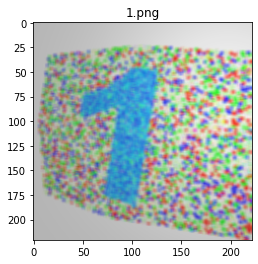

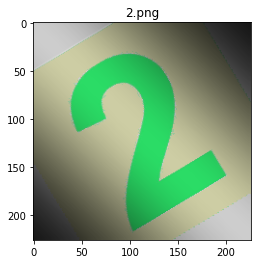

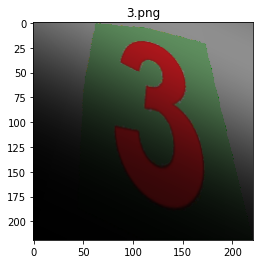

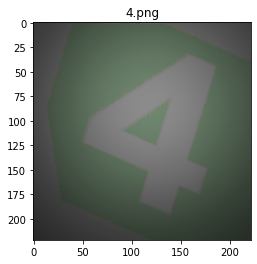

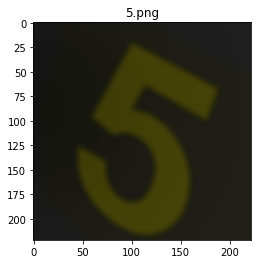

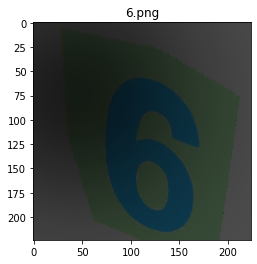

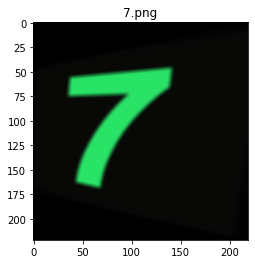

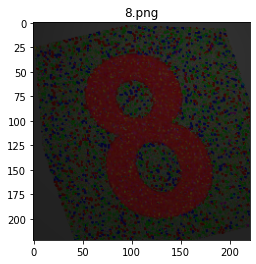

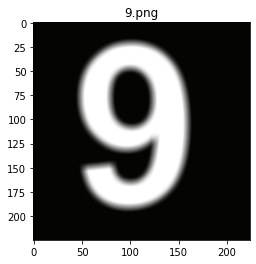

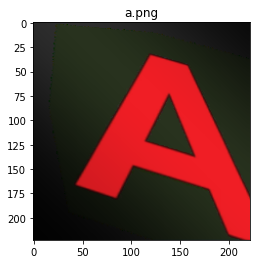

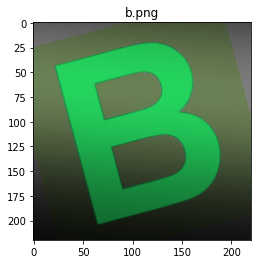

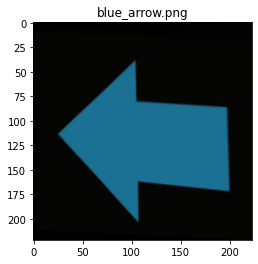

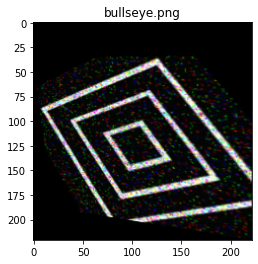

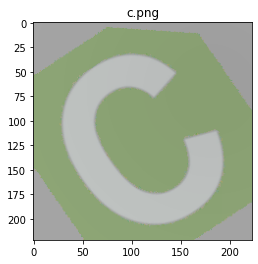

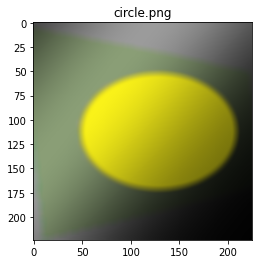

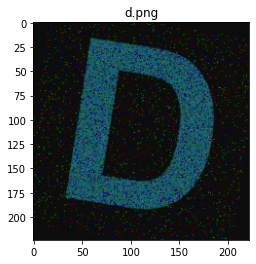

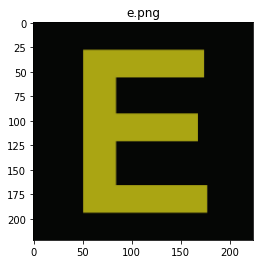

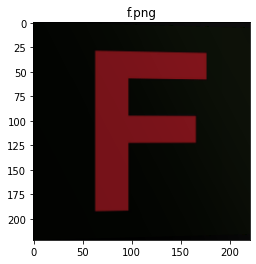

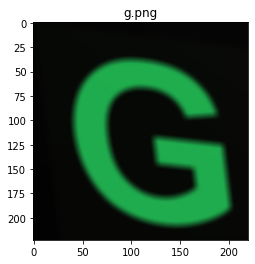

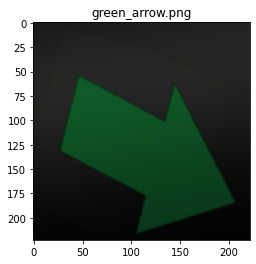

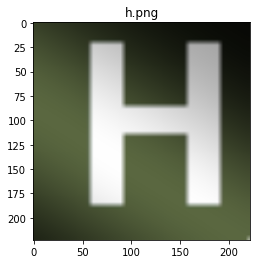

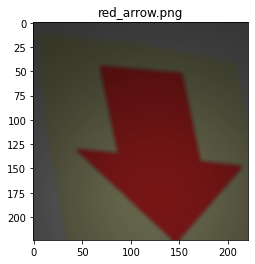

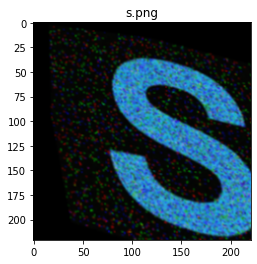

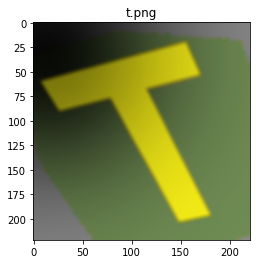

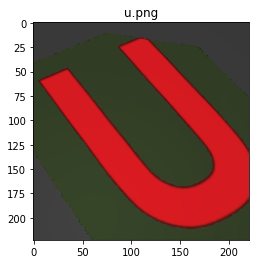

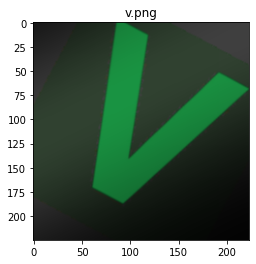

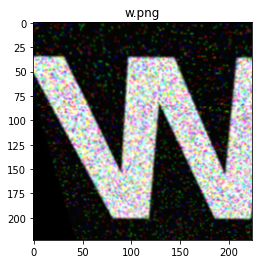

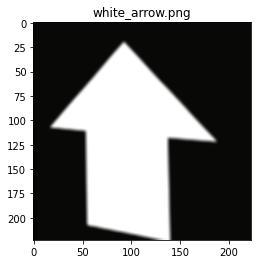

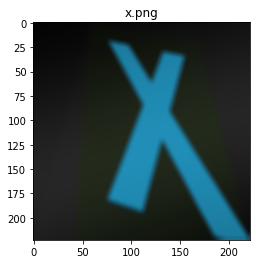

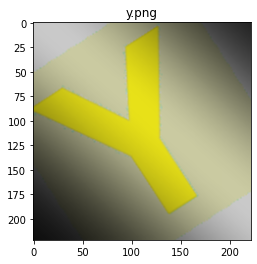

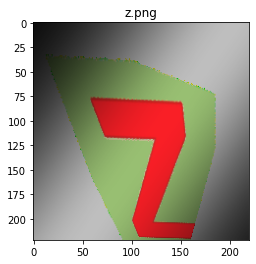

<Figure size 432x288 with 0 Axes>

In [71]:
BACKGROUND_IMAGES_DIR = 'background_images'
FOREGROUND_IMAGES_DIR = 'foreground_images'
GENERATED_IMAGES_DIR = 'generated_images'
for fg_image in os.listdir(FOREGROUND_IMAGES_DIR):
    foreground_image_path = os.path.join(FOREGROUND_IMAGES_DIR, fg_image)
    img2 = cv2.imread(foreground_image_path)
    h, w, c = img2.shape
    img3 = random_transformations(img2)
    img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    plt.imshow(img3)
    plt.title(fg_image)
    plt.figure()

In [301]:
uuid.uuid4()

UUID('5b0fb8df-ad13-4430-90b7-31529152b9ea')

In [72]:
BACKGROUND_IMAGES_DIR = 'background_images'
FOREGROUND_IMAGES_DIR = 'foreground_images'
GENERATED_IMAGES_DIR = 'generated_images'
MAXIMUM_BG_IMAGE_SIZE = 2000
VALIDATION_PROBABILITY = 0.25

classes = generate_classes(FOREGROUND_IMAGES_DIR)
print(classes)
print(len(classes))

required_directories = [
    os.path.join(os.getcwd(), GENERATED_IMAGES_DIR, 'images', 'train'),
    os.path.join(os.getcwd(), GENERATED_IMAGES_DIR, 'images', 'val'),
    os.path.join(os.getcwd(), GENERATED_IMAGES_DIR, 'labels', 'train'),
    os.path.join(os.getcwd(), GENERATED_IMAGES_DIR, 'labels', 'val'),
]
for directory in required_directories:
    if not os.path.exists(directory):
        os.makedirs(directory)


with open(os.path.join(GENERATED_IMAGES_DIR, 'classes.txt'), 'w') as f:
    f.write('\n'.join(classes))

for i in range(2):
    for bg_image in os.listdir(BACKGROUND_IMAGES_DIR):
        for fg_image in os.listdir(FOREGROUND_IMAGES_DIR):
            try:
                background_image_path = os.path.join(BACKGROUND_IMAGES_DIR, bg_image)
                foreground_image_path = os.path.join(FOREGROUND_IMAGES_DIR, fg_image)

                # Load two images
                img1 = cv2.imread(background_image_path)
                img2 = cv2.imread(foreground_image_path)

                # Get dimensions of image
                h1, w1, c1 = img1.shape
                h2, w2, c2 = img2.shape
                
                # random transformations on fg image
                img2 = random_transformations(img2)
                # Get new dimensions of fg image after transformations
                h2, w2, c2 = img2.shape

                # plt.imshow(img2)
                # plt.figure()
                
                # random crop on bg
                new_bg_width = random.randint(w2, min(w1, MAXIMUM_BG_IMAGE_SIZE))
                new_bg_height = random.randint(h2, min(h1, MAXIMUM_BG_IMAGE_SIZE))
                new_bg_h_offset = random.randint(0, h1 - new_bg_height)
                new_bg_w_offset = random.randint(0, w1 - new_bg_width)
                img1 = crop_image(img1, new_bg_w_offset, new_bg_h_offset, new_bg_width, new_bg_height)

                img1 = random_transformations(img1, no_rotate=True)
                # Get new dimensions of bg image after transformations
                h1, w1, c1 = img1.shape

                # Place foreground anywhere inside background
                h_offset = random.randint(0, max(h1 - h2, 0))
                w_offset = random.randint(0, max(w1 - w2, 0))

                final_image = stack_images(img1, img2, h_offset, w_offset)
                if random.uniform(0, 1) < 0.8:
                    final_image = random_transformations(final_image, no_rotate=True)

                final_image_name = str(uuid.uuid4())
                class_index = get_class_index(classes, foreground_image_path)
                final_label = generate_yolo_label(class_index, h1, w1, h2, w2, h_offset, w_offset)

                dir_type = 'train' if random.uniform(0, 1) > VALIDATION_PROBABILITY else 'val'
                image_save_location = os.path.join(GENERATED_IMAGES_DIR, 'images', dir_type, final_image_name) + ".jpg"
                label_save_location = os.path.join(GENERATED_IMAGES_DIR, 'labels', dir_type, final_image_name) + ".txt"
                cv2.imwrite(image_save_location, final_image)

                with open(label_save_location, "w") as f:
                    f.write(final_label)

            except Exception as e:
                print("Fail", e)
                continue
        

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'blue_arrow', 'bullseye', 'c', 'circle', 'd', 'e', 'f', 'g', 'green_arrow', 'h', 'red_arrow', 's', 't', 'u', 'v', 'w', 'white_arrow', 'x', 'y', 'z']
31
Fail OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'

Fail OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'

Fail OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'

Fail OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV

In [31]:
background_image_path = 'background_images/2008.jpg'
foreground_image_path = 'foreground_images/6.png'

foreground_image = cv2.imread(foreground_image_path)
foreground_image = cv2.cvtColor(foreground_image, cv2.COLOR_BGR2RGB)
foreground_image = cv2.resize(foreground_image, (200, 200))
# background_image = cv2.imread(background_image_path)
# background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

# x = 100
# y = 100
w, h, c = foreground_image.shape

rot_mat = np.array([[0.707, 0.707, 0], [-0.707, 0.707, 0], [0, 0, 1]])
print(rot_mat)
foreground_image = cv2.warpAffine(foreground_image, rot_mat, (w, h))
plt.imshow(foreground_image)

# start_point = (x, y)
# end_point = (x + w, y + h)

# resultant_image = stack_images(background_image, foreground_image, 100, 100)
# resultant_image = cv2.rectangle(resultant_image, start_point, end_point, (255, 0, 0), thickness=5)
# resultant_image = rotate_image(resultant_image, 20)
# plt.imshow(resultant_image)
# plt.figure()

[[ 0.707  0.707  0.   ]
 [-0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]


error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:2604: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'warpAffine'
